# Plant Disease Detection Classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.svm import SVC

from xgboost import XGBClassifier


## Model Architecture 

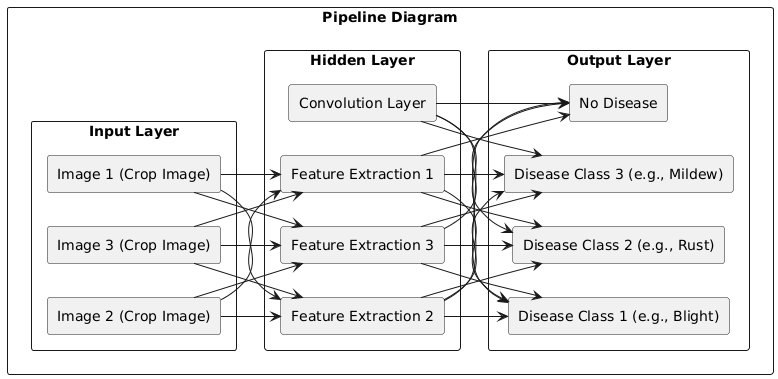

In [26]:
# Set batch size and image size
batch_size = 32
img_size = (128, 128)

training_set = tf.keras.utils.image_dataset_from_directory(
    '/Users/samenergy/Desktop/New Plant Diseases Dataset(Augmented)/Data/train', label_mode="categorical", batch_size=batch_size, image_size=img_size, shuffle=True
) 

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/Users/samenergy/Desktop/New Plant Diseases Dataset(Augmented)/Data/valid', label_mode="categorical", batch_size=batch_size, image_size=img_size, shuffle=False
)  

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [77]:
# Convert dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)


In [24]:
x_train, y_train = dataset_to_numpy(training_set)
x_val, y_val = dataset_to_numpy(validation_set)

x_train_flat = x_train.reshape(len(x_train), -1)
x_val_flat = x_val.reshape(len(x_val), -1)


2025-02-21 15:44:00.885678: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:

# Apply PCA to Reduce Dimensionality
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(x_train_flat)
x_val_pca = pca.transform(x_val_flat)

# Convert one-hot labels to categorical labels for ML models
y_train_flat = np.argmax(y_train, axis=1)
y_val_flat = np.argmax(y_val, axis=1)

In [8]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train_pca, y_train_flat)
y_pred_log_reg = log_reg.predict(x_val_pca)
print("Logistic Regression - Accuracy:", accuracy_score(y_val_flat, y_pred_log_reg))
print("Logistic Regression - F1 Score:", f1_score(y_val_flat, y_pred_log_reg, average='weighted'))


Logistic Regression - Accuracy: 0.645003414523105
Logistic Regression - F1 Score: 0.6387793394221865


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
# Support Vector Machine (SVM)
svm = SVC(kernel='rbf', C=1.0)
svm.fit(x_train_pca, y_train_flat)
y_pred_svm = svm.predict(x_val_pca)
print("SVM - Accuracy:", accuracy_score(y_val_flat, y_pred_svm))
print("SVM - F1 Score:", f1_score(y_val_flat, y_pred_svm, average='weighted'))



SVM - Accuracy: 0.8166401092647394
SVM - F1 Score: 0.8149271184448996


In [9]:
# XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50)
xgb.fit(x_train_pca, y_train_flat)
y_pred_xgb = xgb.predict(x_val_pca)
print("XGBoost - Accuracy:", accuracy_score(y_val_flat, y_pred_xgb))
print("XGBoost - F1 Score:", f1_score(y_val_flat, y_pred_xgb, average='weighted'))

/Users/samenergy/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:28:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7196107443660369
XGBoost - F1 Score: 0.7185815660939736


In [27]:
# Define the model for Simple NN model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(38, activation='softmax')  
])

/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_set, epochs=10, validation_data=validation_set)


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 243s 111ms/step - accuracy: 0.7140 - loss: 0.9459 - val_accuracy: 0.8893 - val_loss: 0.3585
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 244s 111ms/step - accuracy: 0.9022 - loss: 0.3081 - val_accuracy: 0.8993 - val_loss: 0.3224
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 239s 109ms/step - accuracy: 0.9370 - loss: 0.1921 - val_accuracy: 0.9122 - val_loss: 0.2939
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 241s 110ms/step - accuracy: 0.9553 - loss: 0.1350 - val_accuracy: 0.9179 - val_loss: 0.2798
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 235s 107ms/step - accuracy: 0.9649 - loss: 0.1063 - val_accuracy: 0.9317 - val_loss: 0.2474
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 243s 111ms/step - accuracy: 0.9726 - loss: 0.0826 - val_accuracy: 0.9195 - val_loss: 0.3093
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 243s 111ms/step - accuracy: 0.9782 - loss: 0.0666 - val_accuracy: 0.9153 - val_loss: 0.3432
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 245s 112ms/step - ac

550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step

Classification Report:
 {'0': {'precision': 0.9535864978902954, 'recall': 0.8968253968253969, 'f1-score': 0.9243353783231084, 'support': 504.0}, '1': {'precision': 0.967948717948718, 'recall': 0.9114688128772636, 'f1-score': 0.938860103626943, 'support': 497.0}, '2': {'precision': 0.9622641509433962, 'recall': 0.9272727272727272, 'f1-score': 0.9444444444444444, 'support': 440.0}, '3': {'precision': 0.9534883720930233, 'recall': 0.898406374501992, 'f1-score': 0.9251282051282051, 'support': 502.0}, '4': {'precision': 0.9573991031390134, 'recall': 0.9405286343612335, 'f1-score': 0.9488888888888889, 'support': 454.0}, '5': {'precision': 0.9665071770334929, 'recall': 0.9596199524940617, 'f1-score': 0.9630512514898689, 'support': 421.0}, '6': {'precision': 0.9821826280623608, 'recall': 0.9671052631578947, 'f1-score': 0.974585635359116, 'support': 456.0}, '7': {'precision': 0.9042821158690176, 'recall': 0.875609756097561, 'f1-score': 0.8897149938042

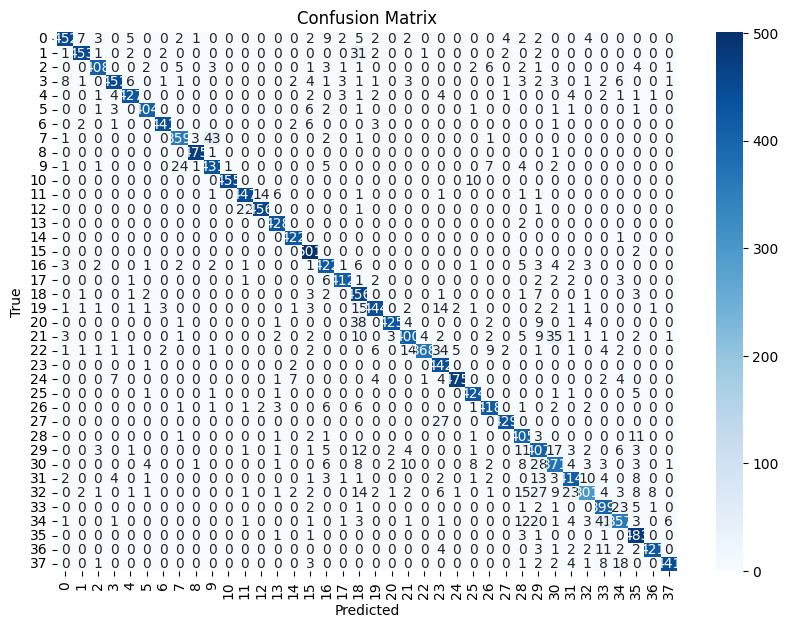

Accuracy: 0.9175961757341224
F1 Score: 0.9177109604198656
Precision: 0.9213131785991244
Recall: 0.91779856297828


In [ ]:
# Evaluate the model
y_pred = model.predict(validation_set)
y_true = np.concatenate([y for x, y in validation_set], axis=0)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Calculate accuracy, precision, recall, F1 score, and confusion matrix
accuracy = np.mean(y_pred_labels == y_true_labels)
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)


print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(38), yticklabels=np.arange(38))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

f1_score = report['macro avg']['f1-score']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

model.save('Simple_NN_Model.keras')

In [15]:

def define_model(optimization, regularization=None, dropout=0.0, learning_rate=0.001, early_stopping=False):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularization, input_shape=(128,128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularization))
    model.add(Dropout(dropout))
    model.add(Dense(38, activation='softmax'))
    
    optimizers = {
        'Adam': Adam(learning_rate=learning_rate),
        'RMSprop': RMSprop(learning_rate=learning_rate),
        'SGD': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        'Nadam': Nadam(learning_rate=learning_rate)
    }
    
    model.compile(optimizer=optimizers[optimization], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)] if early_stopping else []
    
    history = model.fit(training_set, epochs=10, validation_data=validation_set, callbacks=callbacks, verbose=2)
    return model, history

In [16]:
def plot_loss_curve(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training loss')  # Blue line for training loss
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation loss')  # Red line for validation loss
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [17]:


def evaluate_model(model, data):
    y_true = []
    y_pred = []

    for images, labels in data:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=-1))  # Convert one-hot labels to class indices
        y_pred.extend(np.argmax(preds, axis=-1))  # Convert predictions to class indices

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f'Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    # Confusion matrix with improved visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()



Epoch 1/10


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2197/2197 - 342s - 156ms/step - accuracy: 0.3630 - loss: 3.1001 - val_accuracy: 0.2016 - val_loss: 4.8850
Epoch 2/10
2197/2197 - 331s - 151ms/step - accuracy: 0.6707 - loss: 2.3812 - val_accuracy: 0.6898 - val_loss: 2.3644
Epoch 3/10
2197/2197 - 336s - 153ms/step - accuracy: 0.7681 - loss: 2.0246 - val_accuracy: 0.8059 - val_loss: 1.7754
Epoch 4/10
2197/2197 - 337s - 154ms/step - accuracy: 0.7987 - loss: 1.7562 - val_accuracy: 0.8028 - val_loss: 1.6146
Epoch 5/10
2197/2197 - 341s - 155ms/step - accuracy: 0.8123 - loss: 1.5847 - val_accuracy: 0.7921 - val_loss: 1.5196
Epoch 6/10
2197/2197 - 349s - 159ms/step - accuracy: 0.8238 - loss: 1.5147 - val_accuracy: 0.8010 - val_loss: 1.5503
Epoch 7/10
2197/2197 - 364s - 166ms/step - accuracy: 0.8526 - loss: 1.4462 - val_accuracy: 0.8177 - val_loss: 1.5767
Epoch 8/10
2197/2197 - 357s - 162ms/step - accuracy: 0.8814 - loss: 1.2938 - val_accuracy: 0.8716 - val_loss: 1.3090
Epoch 9/10
2197/2197 - 353s - 161ms/step - accuracy: 0.8869 - loss: 1.2531 

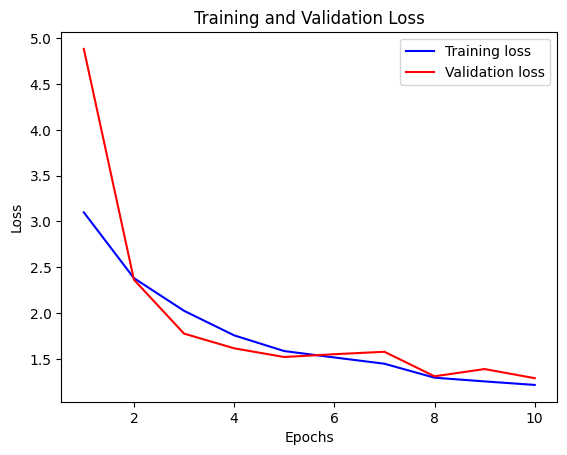

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

2025-02-22 11:52:01.896921: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


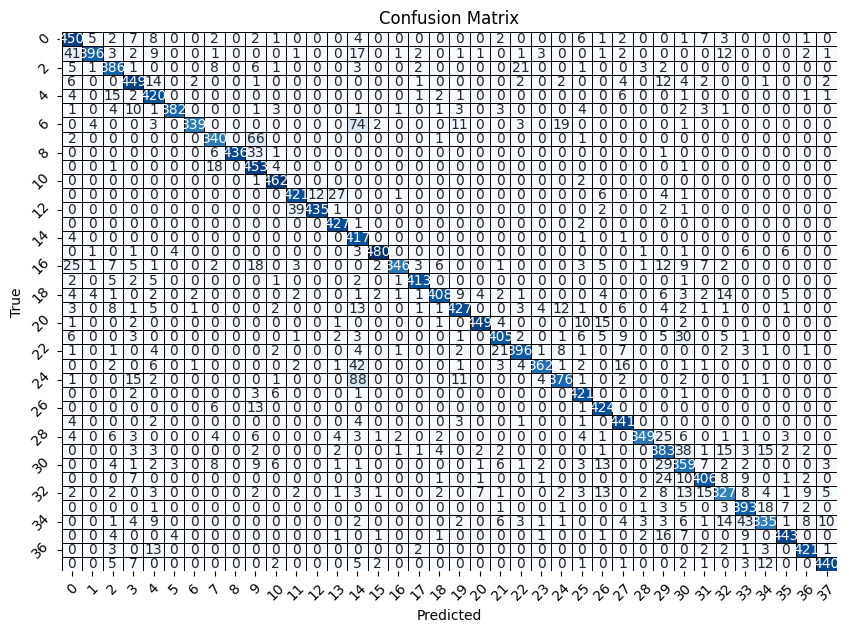

In [18]:
model_1, history_1 = define_model('Nadam', regularization=l2(0.001), early_stopping=True, dropout=0.2, learning_rate=0.001)
plot_loss_curve(history_1)
evaluate_model(model_1, validation_set)

Epoch 1/10


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2197/2197 - 345s - 157ms/step - accuracy: 0.5752 - loss: 7.6639 - val_accuracy: 0.7943 - val_loss: 3.6226
Epoch 2/10
2197/2197 - 349s - 159ms/step - accuracy: 0.7158 - loss: 3.6699 - val_accuracy: 0.8216 - val_loss: 3.2220
Epoch 3/10
2197/2197 - 341s - 155ms/step - accuracy: 0.7698 - loss: 3.2493 - val_accuracy: 0.8279 - val_loss: 3.0011
Epoch 4/10
2197/2197 - 347s - 158ms/step - accuracy: 0.8041 - loss: 2.9635 - val_accuracy: 0.8608 - val_loss: 2.7572
Epoch 5/10
2197/2197 - 344s - 157ms/step - accuracy: 0.8244 - loss: 2.7647 - val_accuracy: 0.8614 - val_loss: 2.6484
Epoch 6/10
2197/2197 - 343s - 156ms/step - accuracy: 0.8399 - loss: 2.6044 - val_accuracy: 0.8625 - val_loss: 2.5227
Epoch 7/10
2197/2197 - 340s - 155ms/step - accuracy: 0.8515 - loss: 2.4750 - val_accuracy: 0.8403 - val_loss: 2.5765
Epoch 8/10
2197/2197 - 344s - 157ms/step - accuracy: 0.8626 - loss: 2.3663 - val_accuracy: 0.8668 - val_loss: 2.3587
Epoch 9/10
2197/2197 - 339s - 154ms/step - accuracy: 0.8686 - loss: 2.3079 

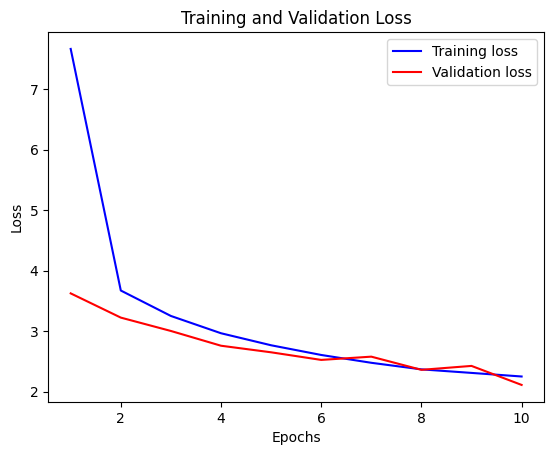

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

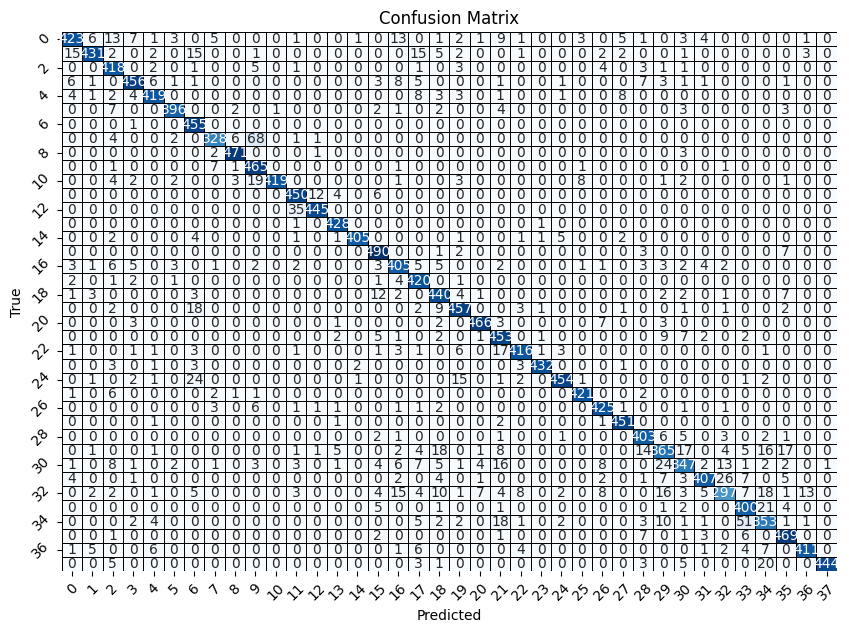

In [25]:

model_2, history_2 = define_model('RMSprop', regularization=l1(0.0005), early_stopping=True, dropout=0.3, learning_rate=0.0001)
plot_loss_curve(history_2)
evaluate_model(model_2, validation_set)



Epoch 1/10


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2197/2197 - 302s - 137ms/step - accuracy: 0.4597 - loss: 2.0476 - val_accuracy: 0.7556 - val_loss: 0.9262
Epoch 2/10
2197/2197 - 299s - 136ms/step - accuracy: 0.6735 - loss: 1.1676 - val_accuracy: 0.8148 - val_loss: 0.6654
Epoch 3/10
2197/2197 - 299s - 136ms/step - accuracy: 0.7522 - loss: 0.8683 - val_accuracy: 0.8495 - val_loss: 0.5458
Epoch 4/10
2197/2197 - 303s - 138ms/step - accuracy: 0.8001 - loss: 0.6969 - val_accuracy: 0.8517 - val_loss: 0.5260
Epoch 5/10
2197/2197 - 317s - 144ms/step - accuracy: 0.8308 - loss: 0.5881 - val_accuracy: 0.8688 - val_loss: 0.4746
Epoch 6/10
2197/2197 - 309s - 140ms/step - accuracy: 0.8531 - loss: 0.5063 - val_accuracy: 0.8717 - val_loss: 0.4564
Epoch 7/10
2197/2197 - 304s - 139ms/step - accuracy: 0.8678 - loss: 0.4586 - val_accuracy: 0.8732 - val_loss: 0.4760
Epoch 8/10
2197/2197 - 306s - 139ms/step - accuracy: 0.8811 - loss: 0.4127 - val_accuracy: 0.8772 - val_loss: 0.4421
Epoch 9/10
2197/2197 - 311s - 142ms/step - accuracy: 0.8872 - loss: 0.3873 

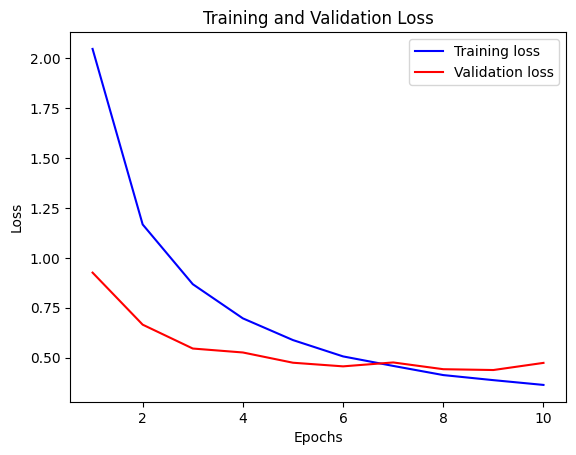

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

2025-02-22 00:48:20.432726: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


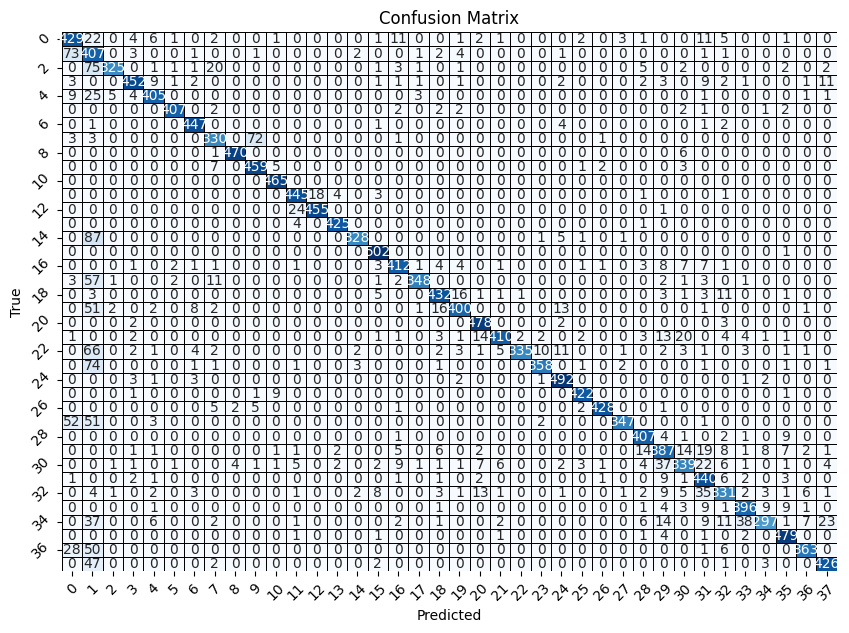

In [26]:
model_3, history_3 = define_model('Adam', regularization=None, early_stopping=True, dropout=0.5, learning_rate=0.0001)
plot_loss_curve(history_3)
evaluate_model(model_3, validation_set)


Epoch 1/10


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2197/2197 - 311s - 142ms/step - accuracy: 0.5826 - loss: 1.8075 - val_accuracy: 0.6577 - val_loss: 1.4810
Epoch 2/10
2197/2197 - 304s - 138ms/step - accuracy: 0.7890 - loss: 1.0054 - val_accuracy: 0.8482 - val_loss: 0.8072
Epoch 3/10
2197/2197 - 303s - 138ms/step - accuracy: 0.8622 - loss: 0.7534 - val_accuracy: 0.8939 - val_loss: 0.6533
Epoch 4/10
2197/2197 - 303s - 138ms/step - accuracy: 0.9040 - loss: 0.6112 - val_accuracy: 0.8691 - val_loss: 0.7414
Epoch 5/10
2197/2197 - 304s - 139ms/step - accuracy: 0.9294 - loss: 0.5215 - val_accuracy: 0.9110 - val_loss: 0.5986
Epoch 6/10
2197/2197 - 304s - 139ms/step - accuracy: 0.9440 - loss: 0.4674 - val_accuracy: 0.9118 - val_loss: 0.5774
Epoch 7/10
2197/2197 - 303s - 138ms/step - accuracy: 0.9536 - loss: 0.4266 - val_accuracy: 0.9030 - val_loss: 0.6366
Epoch 8/10
2197/2197 - 302s - 138ms/step - accuracy: 0.9627 - loss: 0.3930 - val_accuracy: 0.9126 - val_loss: 0.5841
Epoch 9/10
2197/2197 - 303s - 138ms/step - accuracy: 0.9694 - loss: 0.3625 

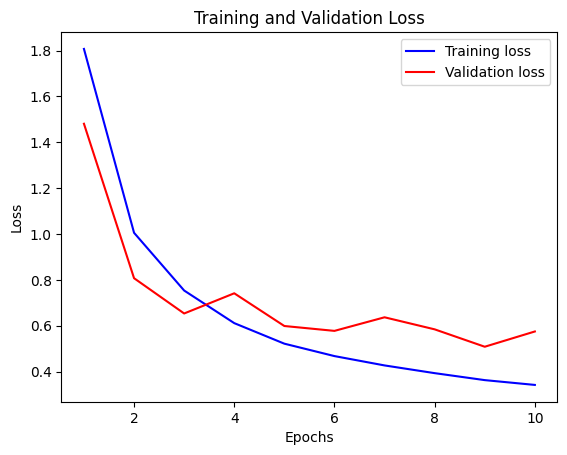

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

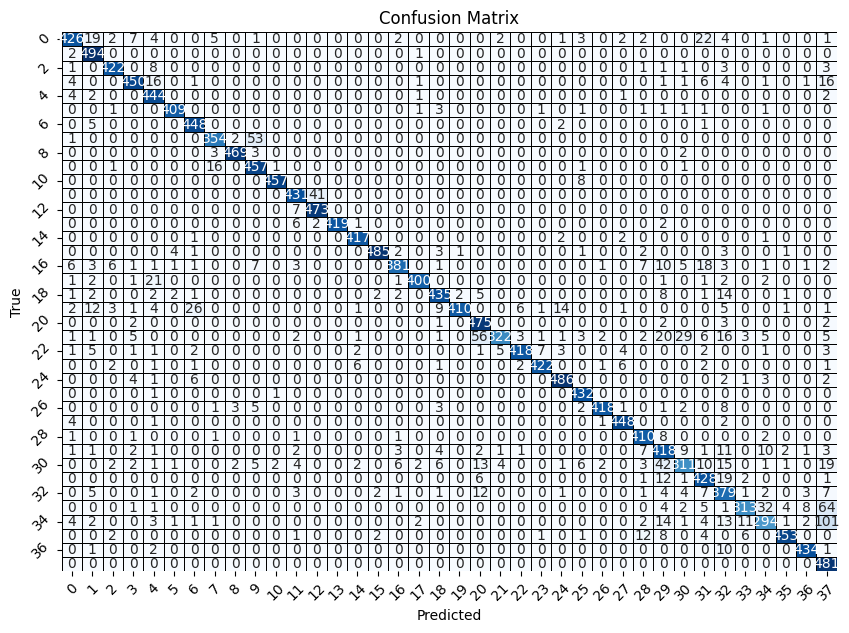

In [27]:
model_4, history_4 = define_model('SGD', regularization=l2(0.001), early_stopping=False, dropout=0.3, learning_rate=0.001)
plot_loss_curve(history_4)
evaluate_model(model_4, validation_set)

In [21]:


save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

model_1.save(os.path.join(save_dir, 'model_1_Nadam.keras'))

model_2.save(os.path.join(save_dir, 'model_2_RMSprop.keras'))

model_3.save(os.path.join(save_dir, 'model_3_Adam.keras'))

model_4.save(os.path.join(save_dir, 'model_4_SGD.keras'))

print("models saved successfully in 'saved_models' folder")


models saved successfully in 'saved_models' folder


In [ ]:


save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

svm_path = os.path.join(save_dir, "svm_rbf_C1.pkl")
joblib.dump(svm, svm_path)

print(f"SVM model saved successfully at: {svm_path}")


SVM model saved successfully at: saved_models/svm_rbf_C1.pkl


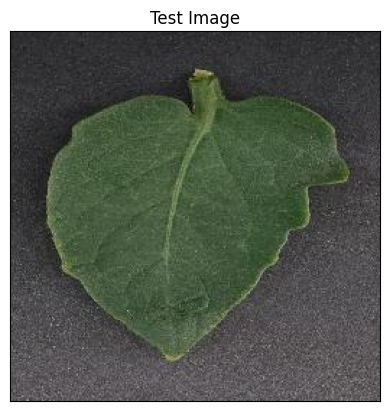

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted class index: 30
Predicted Disease: Tomato___healthy


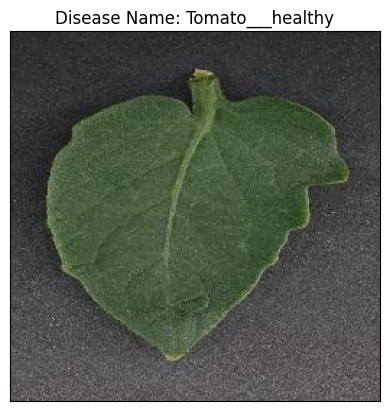

In [7]:


model = tf.keras.models.load_model(r'C:\Users\M\Pictures\New folder\model_4_SGD.keras')

image_path = r"C:\Users\M\Pictures\New folder\Data\Tests\test\TomatoHealthy2.JPG"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

plt.imshow(img)
plt.title("Test Image")
plt.xticks([])
plt.yticks([])
plt.show()

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)  
input_arr = input_arr / 255.0  

print(input_arr.shape)


prediction = model.predict(input_arr)
prediction, prediction.shape

result_index = np.argmax(prediction)
print(f"Predicted class index: {result_index}")

class_name = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

model_prediction = class_name[result_index]
print(f"Predicted Disease: {model_prediction}")

plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()
